# Kite Project - Multiple Shooting

In [3]:
from sys import path
path.append(r"C:\Users\wzx05\Desktop\ss2020\MPC\code\casadi-windows-py36-v3.5.1-64bit")
from casadi import *
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

In [44]:
# set constants and parameters
# tunable parameters
T = 60 #time horizon 
N = 600 #number of control intervals
E_0 = 5 #base glide ratio [4,6]
v_m = 10 #wind speed[8,12]
v_A = 0.5 #amplitude[0,1]
v_f = 0.10 #frequency [0.05,0.15]
v_off = pi #offset [0,2*pi]


#static parametes
c_hat = 0.028 #related correction coefficent
betha = 0 #the relation between the orientation of the boat and the direction of the wind
A = 300 #area of the kite 
length = 400 #the length of the tether
rho = 1 #air desity
w_F = 1e-4 #the weight for the tension
w_u = 0.5 #punishes changes in control input to obtain a smooth behavior

In [45]:
# declare model variables
x1 = MX.sym('x1')  #theta [0,pi/2]
x2 = MX.sym('x2')  #phi [-pi/2,pi/2]
x3 = MX.sym('x3') #psi [0,2pi]
x4 = MX.sym('x4')  #x4 is the time
x = vertcat(x1,x2,x3,x4)
u_hat = MX.sym('u_hat')
u_old = 0


In [46]:
#parametes
v_0 = v_m + v_A*sin(2*pi*v_f*x4+v_off)
E = E_0 - c_hat*(u_hat)**2
v_a = v_0*E*cos(x1)
P_D = rho*v_0**2/2
T_F = P_D*A*cos(x1)**2*(E+1)*sqrt(E**2+1)*(cos(x1)*cos(betha)+sin(x1)*sin(betha)*sin(x2))


In [47]:
# Critical constraint of the height of the kite
h = length*sin(x1)*cos(x2)
h_min = 100 #the length of kite should never be lower than h_min.

In [48]:
#model equations
x1_dot = v_a/length*(cos(x3)-tan(x1)/E)
x2_dot = -v_a/(length*sin(x1))*sin(x3)
x3_dot = v_a/length*u_hat+x2_dot*cos(x1)
x4_dot = 1
xdot = vertcat(x1_dot,x2_dot,x3_dot,x4_dot)

In [49]:
#Objective term
L = -w_F*T_F  + w_u*(u_hat-u_old)**2

In [50]:
#formulate discrete time dynamics
if False:
    dae = struct('x',x,'p',u_hat,'ode',xdot,'quad',L)
    opts = struct('tf',T/N)
    F = integrator('F', 'cvodes', dae, opts)
else:
    #Fixed step Runge-Kutta 4 integrator
    M = 4
    DT = T/N/M
    f = Function('f',[x, u_hat], [xdot, L])
    X0 = MX.sym('X0',4)
    U = MX.sym('U')
    X = X0
    Q = 0
    for j in range(M):
        k1, k1_q = f(X, U)
        k2, k2_q = f(X + DT/2 * k1, U)
        k3, k3_q = f(X + DT/2 * k2, U)
        k4, k4_q = f(X + DT * k3, U)
        X = X + DT/6*(k1 +2*k2 +2*k3 +k4)
        Q = Q + DT/6*(k1_q + 2*k2_q + 2*k3_q + k4_q)
    F = Function('F', [X0, U], [X, Q], ['x0','p'], ['xf', 'qf'])
        


In [51]:
#start with an empty nlp
w=[]
w0 = []
lbw = []
ubw = []
J = 0
g=[]
lbg = []
ubg = []

In [52]:
#"lift" initial conditions, choose specific initial state: [20,30,0,0].T

Xk = MX.sym('x0',4)
w += [Xk]
lbw += [ pi/9, pi/6,0, 0]
ubw += [ pi/9, pi/6, 0, 0]
w0 += [pi/9, pi/6, 0, 0]               
x_opt = [pi/9, pi/6, 0, 0]     
u_opt = []

In [53]:
for k in range(N):
    Uk = MX.sym('U_' + str(k))
    w   += [Uk]
    lbw += [-10]
    ubw += [10]
    w0  += [0]
    # Integrate till the end of the interval
    Fk = F(x0=Xk, p=Uk)
    Xk_end = Fk['xf']
    J=J+Fk['qf']
    # New NLP variable for state at end of interval
    Xk = MX.sym('X_' + str(k+1), 4)
    w   += [Xk]
    lbw += [0, -pi/2, 0, -inf]
    ubw += [pi/2, pi/2, 2*pi, inf]
    w0  += [0, 0, 0, 0]
    # Add equality constraint
    # h = length*sin(x1)*cos(x2)
    g   += [vertcat(Xk_end-Xk,  length*sin(Xk[0])*cos(Xk[1]))]
    lbg += [0, 0, 0, 0, h_min]
    ubg += [0, 0, 0, 0, inf]

print(vertcat(*w))
print(vertcat(*g))

X_293), ((400*sin(X_293[0]))*cos(X_293[1])), (F(X_293, U_293){0}-X_294), ((400*sin(X_294[0]))*cos(X_294[1])), (F(X_294, U_294){0}-X_295), ((400*sin(X_295[0]))*cos(X_295[1])), (F(X_295, U_295){0}-X_296), ((400*sin(X_296[0]))*cos(X_296[1])), (F(X_296, U_296){0}-X_297), ((400*sin(X_297[0]))*cos(X_297[1])), (F(X_297, U_297){0}-X_298), ((400*sin(X_298[0]))*cos(X_298[1])), (F(X_298, U_298){0}-X_299), ((400*sin(X_299[0]))*cos(X_299[1])), (F(X_299, U_299){0}-X_300), ((400*sin(X_300[0]))*cos(X_300[1])), (F(X_300, U_300){0}-X_301), ((400*sin(X_301[0]))*cos(X_301[1])), (F(X_301, U_301){0}-X_302), ((400*sin(X_302[0]))*cos(X_302[1])), (F(X_302, U_302){0}-X_303), ((400*sin(X_303[0]))*cos(X_303[1])), (F(X_303, U_303){0}-X_304), ((400*sin(X_304[0]))*cos(X_304[1])), (F(X_304, U_304){0}-X_305), ((400*sin(X_305[0]))*cos(X_305[1])), (F(X_305, U_305){0}-X_306), ((400*sin(X_306[0]))*cos(X_306[1])), (F(X_306, U_306){0}-X_307), ((400*sin(X_307[0]))*cos(X_307[1])), (F(X_307, U_307){0}-X_308), ((400*sin(X_308[0

In [54]:
# Create an NLP solver
prob = {'f': J, 'x': vertcat(*w), 'g': vertcat(*g)}
solver = nlpsol('solver', 'ipopt', prob)    


In [55]:
# Solve the NLP
sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
w_opt = sol['x'].full().flatten()

31424e+002 5.05e-002 2.32e+000  -3.8 3.95e+002  -4.0 8.84e-005 3.51e-003f  1
 407 -4.4331949e+002 7.08e-002 1.15e+001  -3.8 1.03e+001    -  2.13e-001 2.81e-001F  1
 408 -4.4343106e+002 1.09e-001 8.80e+000  -3.8 8.39e+000  -3.6 8.88e-003 2.55e-001f  1
 409 -4.4343119e+002 1.09e-001 8.80e+000  -3.8 1.57e+003    -  2.49e-003 1.33e-006h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410 -4.4380558e+002 4.36e-002 3.67e+000  -3.8 1.87e+000  -3.1 8.98e-001 7.55e-001h  1
 411 -4.4383852e+002 5.93e-002 5.87e+000  -3.8 1.57e+003    -  2.05e-005 9.13e-004f  1
 412 -4.4387797e+002 5.92e-002 5.56e+000  -3.8 8.61e+000  -3.6 2.67e-003 5.65e-002f  1
 413 -4.4391011e+002 5.96e-002 5.06e+000  -3.8 2.57e+001    -  9.47e-002 2.05e-002h  1
 414 -4.4394918e+002 6.35e-002 4.94e+000  -3.8 2.45e+001  -4.1 2.70e-003 3.45e-002f  1
 415 -4.4401721e+002 6.68e-002 4.25e+000  -3.8 8.54e+000  -3.7 3.28e-002 1.29e-001f  1
 416 -4.4406760e+002 6.47e-002 4.00e+000  -3.8 1.31e+001   

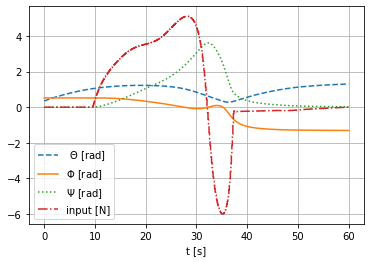

<Figure size 432x288 with 0 Axes>

In [56]:
# Plot the solution
x1_opt = w_opt[0::5]
x2_opt = w_opt[1::5]
x3_opt = w_opt[2::5]
x4_opt = w_opt[3::5]
u_opt = w_opt[4::5]

tgrid = [T/N*k for k in range(N+1)]

import matplotlib.pyplot as plt
plt.figure(1)
plt.clf()
plt.plot(tgrid, x1_opt, '--')
plt.plot(tgrid, x2_opt, '-')
plt.plot(tgrid, x3_opt, ':')
#plt.plot(tgrid, x4_opt, '-.')

plt.step(tgrid, vertcat(DM.nan(1), u_opt), '-.')

plt.xlabel('t [s]')
plt.legend([' $\Theta$ [rad]','$\Phi$ [rad]','$\Psi$ [rad] ','input [N]'])
plt.grid()
plt.show()
plt.savefig('x_u_img')

In [57]:
h_opt = length*sin(x1_opt)*cos(x2_opt)

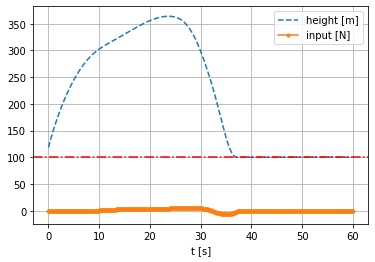

In [58]:
my_u = np.concatenate((u_opt,u_opt[-1].reshape(1,)),axis=0)

plt.figure()
plt.plot(tgrid, h_opt, '--')
plt.plot(tgrid, my_u, '.-')
plt.xlabel('t [s]')
plt.axhline(y=100,color='r',linestyle='-.')

plt.legend(['height [m]','input [N]'])
plt.grid()
plt.show()

Text(0, 0.5, 'input')

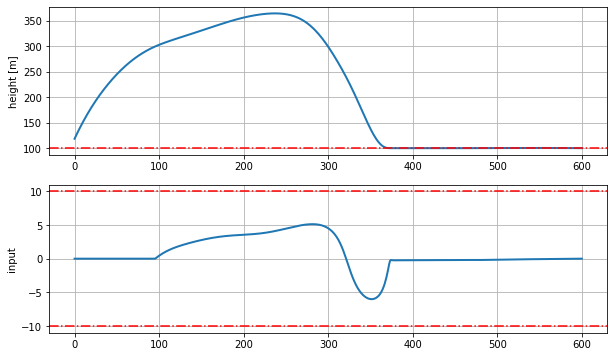

In [60]:
fig, ax = plt.subplots(2,1,figsize=(10,6))
ax[0].grid()
ax[0].plot(h_opt,linewidth=2)
ax[0].axhline(y=100,color='r',linestyle='-.')
ax[0].set_ylabel('height [m]')
ax[1].plot(my_u,linewidth=2)
ax[1].axhline(y=10,color='r',linestyle='-.')
ax[1].axhline(y=-10,color='r',linestyle='-.')
ax[1].grid()
ax[1].set_ylabel('input')


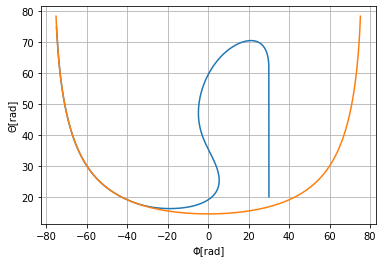

In [61]:
#plot trajactory

x1_opt_rad = x1_opt*180/pi
x2_opt_rad = x2_opt*180/pi
plt.plot(x2_opt_rad,x1_opt_rad)
plt.xlabel('\u03A6[rad]')
plt.ylabel('\u0398[rad]')

X=np.linspace(-90,90,500)
Y=arcsin(100/length/cos(X/180*pi))


plt.plot(X,Y/np.pi*180)
plt.grid()
plt.show()

Text(0.5, 1.0, 'The average Tension is 108612.59N')

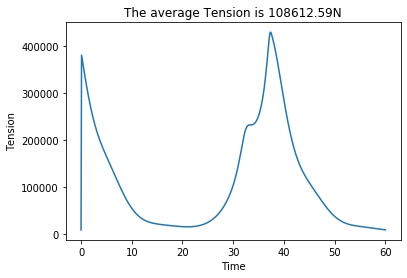

In [62]:
Tf = Function("Tf",[x,u_hat],[T_F])

x1_a = x1_opt.reshape((-1,1))
x2_a = x2_opt.reshape((-1,1))
x3_a = x3_opt.reshape((-1,1))
x4_a = x4_opt.reshape((-1,1))
my_x = np.concatenate((x1_a,x2_a,x3_a,x4_a),axis=1)

T=[]
sumT=0
t=np.linspace(0,60,my_u.T.shape[0])
for i in range(my_u.T.shape[0]):
    newT=Tf(my_x[i-1],my_u[i-1])
    T.append(newT)
    sumT+=newT

plt.plot(t,T)
plt.xlabel('Time')
plt.ylabel('Tension')
plt.title('The average Tension is %.2fN' % np.mean(T))